
# Aplicación de Mejores Prácticas de Codificación en el Pipeline de Modelado

Este notebook aplica el **Punto 3** de la Fase 2 | Avance de proyecto: uso de buenas prácticas de codificación en un pipeline de modelado con **Scikit-Learn**.

Incluye:
- Preprocesamiento con `ColumnTransformer`
- Pipelines reproducibles (`Pipeline`)
- Entrenamiento, evaluación y tuning (`GridSearchCV`, `RandomizedSearchCV`)
- Generación de métricas y reporte automatizado

Autor: Francisco Saavedra Suárez  
Fecha de ejecución automática: 2025-10-31


In [3]:

import numpy as np
import pandas as pd
import os, json, time
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from scipy.stats import randint

RANDOM_SEED = 42


## 1. Carga del Dataset

In [4]:
# === 1. Montar Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. Cargar datasets desde la carpeta MLOPs ===
import pandas as pd

path = "/content/drive/MyDrive/MLOPs/"

Mounted at /content/drive


In [5]:

# Ajusta la ruta según tu entorno (ejemplo: Google Drive o local)
path = "/content/drive/MyDrive/MLOPs/power_tetouan_city_after_EDA.csv"
df = pd.read_csv(path)
target = "z1_power_cons"

X = df.drop(columns=[target, "DateTime"], errors="ignore")
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
print("Dataset cargado correctamente:", df.shape)
df.head()


Dataset cargado correctamente: (52416, 13)


,DateTime,temp,hum,wind,gen_diffuse_flows,diffuse_flows,z1_power_cons,z2_power_cons,z3_power_cons,hour,day_of_week,month,day
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1


## 2. Preprocesamiento con `ColumnTransformer`

In [8]:

num_cols = selector(dtype_include=np.number)(X)
cat_cols = selector(dtype_exclude=np.number)(X)

prep = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])


## 3. Modelos Base con Pipelines

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Modelos base con Pipelines
models = {
    "Linear": Pipeline([("prep", prep), ("model", LinearRegression())]),
    "Ridge": Pipeline([("prep", prep), ("model", Ridge(alpha=1.0))]),
    "Lasso": Pipeline([("prep", prep), ("model", Lasso(alpha=0.001, max_iter=5000))]),
    "RandomForest": Pipeline([
        ("prep", prep),
        ("model", RandomForestRegressor(n_estimators=120, max_depth=12, random_state=RANDOM_SEED))
    ])
}

results = []

for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, pred)

    results.append([name, mae, rmse, r2])

baseline = pd.DataFrame(results, columns=["Modelo", "MAE", "RMSE", "R2"]).sort_values("R2", ascending=False)
baseline


,Modelo,MAE,RMSE,R2
3,RandomForest,650.575773,932.689882,0.982772
0,Linear,2041.038522,2626.267358,0.863405
2,Lasso,2041.038767,2626.267375,0.863405
1,Ridge,2041.043855,2626.268904,0.863405


## 4. Ajuste de Hiperparámetros

In [11]:

rf_pipe = Pipeline([("prep", prep), ("model", RandomForestRegressor(random_state=RANDOM_SEED))])
rf_param = {
    "model__n_estimators": randint(200, 600),
    "model__max_depth": randint(4, 20),
    "model__min_samples_split": randint(2, 10),
    "model__min_samples_leaf": randint(1, 8)
}
rf_search = RandomizedSearchCV(rf_pipe, rf_param, n_iter=15, scoring="r2", cv=3, n_jobs=-1, random_state=RANDOM_SEED)
rf_search.fit(X_train, y_train)

ridge_pipe = Pipeline([("prep", prep), ("model", Ridge())])
ridge_grid = {"model__alpha": [0.1, 1.0, 10.0, 100.0]}
ridge_search = GridSearchCV(ridge_pipe, ridge_grid, scoring="r2", cv=3, n_jobs=-1)
ridge_search.fit(X_train, y_train)

rf_best, ridge_best = rf_search.best_estimator_, ridge_search.best_estimator_

pd.DataFrame([
    {"Modelo": "RandomForest (tuned)", "R2": r2_score(y_test, rf_best.predict(X_test))},
    {"Modelo": "Ridge (tuned)", "R2": r2_score(y_test, ridge_best.predict(X_test))}
])


,Modelo,R2
0,RandomForest (tuned),0.988593
1,Ridge (tuned),0.863405


## 5. Importancia de Variables

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


<Axes: title={'center': 'Top 10 variables más importantes'}>

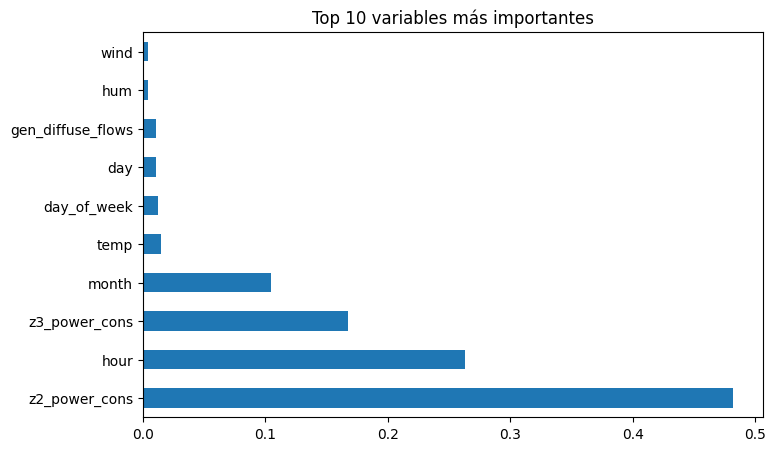

In [12]:

pi = permutation_importance(rf_best, X_test, y_test, n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
importances = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False)
importances.head(10).plot(kind='barh', title='Top 10 variables más importantes', figsize=(8,5))


## 6. Guardar Resultados y Modelo Final

In [13]:

os.makedirs("salidas", exist_ok=True)
baseline.to_csv("salidas/baseline.csv", index=False)
dump(rf_best, "salidas/best_model.joblib")
importances.to_csv("salidas/feature_importance.csv")
print("Archivos guardados en carpeta 'salidas/'")


Archivos guardados en carpeta 'salidas/'
